In this notebook we run TurbPy and examine the sensivity of TurbPy's MOST solutions to:
1. the saturation vapor pressure curve used to calculate surface water vapor pressure from surface temperature measurement
2. choice of surface temperature measusrement (including estimating surface temperature as 2/3-meter surface temperature)

See `sat_vapor_pressure_curve.ipynb`, the analysis which preceded this, `create_turbulence_dataset.ipynb`, where we create one of the datasets we use here, and `most_sensitivity.py`, where we create the model results dataset we use here.

In [1]:
import os

import numpy as np
import pandas as pd

from sublimpy import tidy

import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

# Prerequisite files


* use script `analysis/sail/lidar_wind_profile_synoptic_wind_coherence.py` to download synoptic wind data
* use `cumulative_sublimation.ipynb` to create daily dataset
* use `analysis/sos/create_turbulence_dataset.ipynb` to create SoS tidy dataset and the (disdrometer) precip data

In [2]:
# Inputs
start_date = '20221130'
end_date = '20230517'
met_gothic = 'gucmetM1.b1'
tsi_sail_code = 'guctsiskycoverM1.b1'
data_dir = '/data2/elilouis/sublimationofsnow'
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

# Open Data 

## Measurements

In [3]:
try:
    tidy_df_30Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")

try:
    tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
    
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])


## Model results

In [4]:
ls -lah model_results.parquet

-rw-rw-r--. 1 elilouis elilouis 113M Oct 30 13:01 model_results.parquet


In [5]:
model_df = pd.read_parquet("model_results.parquet")

model_df['scheme'] = model_df['config'].apply(
    lambda v: 'andreas' if 'andreas lengths' in v else 'yang'
)
model_df['z0'] = model_df['config'].apply(
    lambda v: float(v.split(' ')[-1])
)

model_df['e_sat_curve'] = model_df['config'].apply(
    lambda v: 'metpy' if 'metpy' in v else 'alduchov'
)

model_df['surface_measurement'] = model_df['config'].apply(
    lambda v: v.split(' ')[-3]
)

model_df['most_config'] = model_df['config'].apply(lambda s: ' '.join(s.split(' ')[:-3]))
# remove the scalar roughness length parameterization info 
model_df['most_config'] = model_df['most_config'].str.replace(' andreas lengths', '')

model_df.head()

,time,config,latent heat flux,sensible heat flux,zeta,latent heat conductance,sensible heat conductance,scheme,z0,e_sat_curve,surface_measurement,most_config
0,2022-11-29 17:00:00,Standard Tsurf_c e_sat_metpy 1e-05,0.003384,0.002263,NaN,0.003490,0.003490,yang,0.00001,metpy,Tsurf_c,Standard
1,2022-11-29 17:30:00,Standard Tsurf_c e_sat_metpy 1e-05,0.005943,0.000919,NaN,0.004690,0.004690,yang,0.00001,metpy,Tsurf_c,Standard
2,2022-11-29 18:00:00,Standard Tsurf_c e_sat_metpy 1e-05,0.004470,-0.001354,NaN,0.003773,0.003773,yang,0.00001,metpy,Tsurf_c,Standard
3,2022-11-29 18:30:00,Standard Tsurf_c e_sat_metpy 1e-05,0.001274,-0.001298,NaN,0.001657,0.001657,yang,0.00001,metpy,Tsurf_c,Standard
4,2022-11-29 19:00:00,Standard Tsurf_c e_sat_metpy 1e-05,0.000506,-0.000939,NaN,0.001040,0.001040,yang,0.00001,metpy,Tsurf_c,Standard


In [6]:
model_df.most_config.unique()

array(['Standard', 'Louis b = 12', 'MO Marks Dozier',
       'MO Holtslag de Bruin', 'MO Webb NoahMP', 'MO Beljaars Holtslag',
       'MO Cheng Brutsaert'], dtype=object)

In [7]:
measured_data = tidy_df_30Min.query("variable == 'w_h2o__3m_c'")
measured_data

,measurement,variable,height,tower,time,value
3959632,w_h2o_,w_h2o__3m_c,3.0,c,2022-11-29 17:00:00,0.001584
3959633,w_h2o_,w_h2o__3m_c,3.0,c,2022-11-29 17:30:00,0.001530
3959634,w_h2o_,w_h2o__3m_c,3.0,c,2022-11-29 18:00:00,-0.000297
3959635,w_h2o_,w_h2o__3m_c,3.0,c,2022-11-29 18:30:00,0.000404
3959636,w_h2o_,w_h2o__3m_c,3.0,c,2022-11-29 19:00:00,-0.000359
...,...,...,...,...,...,...
3967741,w_h2o_,w_h2o__3m_c,3.0,c,2023-05-17 15:30:00,0.033596
3967742,w_h2o_,w_h2o__3m_c,3.0,c,2023-05-17 16:00:00,0.029292
3967743,w_h2o_,w_h2o__3m_c,3.0,c,2023-05-17 16:30:00,0.025573
3967744,w_h2o_,w_h2o__3m_c,3.0,c,2023-05-17 17:00:00,0.025568


# Calculate r^2 values for model runs

In [8]:
# no_blowing_snow_data = tidy_df_30Min[
#     tidy_df_30Min.variable.isin(["SF_avg_1m_ue", "SF_avg_2m_ue"])
# ].query("value == 0")

# negative_humidity_grad = tidy_df_30Min[
#     tidy_df_30Min.variable == 'q_gradient_3m_c'
# ].query("value < 0")

# times_no_bs_and_negative_q_grad = pd.merge(
#     no_blowing_snow_data[['time']],
#     negative_humidity_grad[['time']],
#     on = 'time',
#     how = 'inner'
# )['time']

# from sklearn.metrics import r2_score

# r2_dict = {}
# for config in model_df.config.unique():
#     this_config_data = model_df[model_df.config == config]
#     merged = measured_data[['time', 'value']].merge(this_config_data[['time', 'latent heat flux']], on='time').set_index("time")
#     merged = merged[['value', 'latent heat flux']].dropna()
#     r2_dict[config] = r2_score(merged['value'], merged['latent heat flux'])

# r2_dict_limited_data = {}
# for config in model_df.config.unique():
#     this_config_data = model_df[model_df.config == config]
#     merged = measured_data[['time', 'value']].merge(this_config_data[['time', 'latent heat flux']], on='time').set_index("time")
#     merged = merged[['value', 'latent heat flux']].dropna()
#     merged = merged.reset_index()[merged.reset_index()['time'].isin(times_no_bs_and_negative_q_grad)]
#     r2_dict_limited_data[config] = r2_score(merged['value'], merged['latent heat flux'])

# print(r2_dict['MO Holtslag de Bruin Tsurf_c e_sat_alduchov 0.0001'])
# print(r2_dict_limited_data['MO Holtslag de Bruin Tsurf_c e_sat_alduchov 0.0001'])

# r2_df = pd.DataFrame({
#     'config': r2_dict.keys(),
#     'r2': r2_dict.values()
# })

In [9]:
# config = 'MO Holtslag de Bruin Tsurf_c e_sat_alduchov 0.0001'
# this_config_data = model_df[model_df.config == config]
# merged = measured_data[['time', 'value']].merge(this_config_data[['time', 'latent heat flux']], on='time').set_index("time")
# merged = merged[['value', 'latent heat flux']].dropna()
# merged = merged.reset_index()[merged.reset_index()['time'].isin(times_no_bs_and_negative_q_grad)]
# merged = merged[merged.time > "2022-12-01"][merged.time < "2023-05-12"]
# r2_score(
#     merged['value'],
#     merged['latent heat flux']
# )

## Make a wide df form the measured data for convenience


In [10]:
VARIABLES = [
    ## Input Variables for Turbpy
    'Tsurf_c',
    'Tsurf_d',
    'Tsurfplanck_c',
    'Tsurfplanck_d',
    'Tsurf_ue',
    'Tsurf_uw',
    'Tsurf_rad_d',
    'P_10m_c',
    ## Input variables for calculating dewpoint temperature
    'T_3m_c',
    'RH_3m_c',
    ## Input Variables
    'spd_3m_c',
    'P_10m_c',
    # 'Tpot_3m_c',
    # 'Tsurfpot_c',
    'airdensity_3m_c',
    'mixingratio_3m_c',
    'Tsurfmixingratio_c',
    # 'T_3m_c',
    ## Measurement Variables
    'w_h2o__3m_c',
    'u*_3m_c',
    'Ri_3m_c',
]

# CREATE WIDE DATAFRAME
wide_df = tidy_df_30Min[tidy_df_30Min.variable.isin(VARIABLES)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()

In [11]:
[v for v in tidy_df_30Min.variable.unique() if 'Tsurf' in v]

['Tsurfairdensity_c',
 'Tsurfairdensity_rad_d',
 'Tsurfmixingratio_c',
 'Tsurfmixingratio_rad_d',
 'Tsurfspecifichumidity_c',
 'Tsurfpot_c',
 'Tsurfpot_rad_d',
 'Tsurfpotvirtual_c',
 'Tsurfpotvirtual_rad_d',
 'Tsurf_c',
 'Tsurf_d',
 'Tsurf_rad_d',
 'Tsurf_ue',
 'Tsurf_uw',
 'Tsurfplanck_c',
 'Tsurfplanck_d',
 'Tsurfplanck_ue',
 'Tsurfplanck_uw',
 'Tsurfvirtual_c',
 'Tsurfvirtual_rad_d',
 'Tsurfvaporpressure_c',
 'Tsurfvaporpressure_rad_d']

In [12]:
wide_df['Tsurfplanck_c']

0      -12.732437
1      -13.225627
2      -13.852748
3      -15.690720
4      -17.101761
          ...    
7978    20.186076
7979    18.326569
7980    17.401835
7981    14.687220
7982    13.159276
Name: Tsurfplanck_c, Length: 7983, dtype: float64

# Look at seasonal cumulative sublimation from all the models

## Fix outliers manually

This one outlier was due to some strange anamoly in the surface temperature measurement

In [13]:
model_df.loc[(model_df.time == "2023-01-22 1400") & (model_df.surface_measurement == 'Tsurf_d'), 'latent heat flux'] = 0
model_df.loc[(model_df.time == "2023-01-22 1400") & (model_df.surface_measurement == 'Tsurf_d'), 'sensible heat flux'] = 0

In [14]:
src_cumsum = pd.DataFrame(model_df.sort_values("time").set_index(
    ["time", "config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"]
).groupby(["config", "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config"])['latent heat flux'].cumsum()).reset_index()
src_cumsum_daily = pd.DataFrame(src_cumsum.set_index("time").groupby(
    ['config', "scheme", "z0", "e_sat_curve", "surface_measurement", "most_config", pd.Grouper(freq='1440Min')]
)['latent heat flux'].max()).reset_index()

In [15]:
from metpy.constants import density_water
seconds_per_30min = 60*30
src_cumsum_daily['latent heat flux (mm)'] = src_cumsum_daily['latent heat flux'].values * seconds_per_30min/density_water.magnitude

In [16]:
tidy_df_30Min = tidy.tidy_df_add_variable(
    tidy_df_30Min,
    tidy_df_30Min.query("variable == 'w_h2o__3m_c'").value.cumsum().values * seconds_per_30min/density_water.magnitude,
    'w_h2o__cum_sub_mm_3m_c',
    "cumulative sublimation",
    3,
    'c'
)

tidy_df_30Min = tidy.tidy_df_add_variable(
    tidy_df_30Min,
    tidy_df_30Min.query("variable == 'w_h2o__3m_d'").value.cumsum().values * seconds_per_30min/density_water.magnitude,
    'w_h2o__cum_sub_mm_3m_d',
    "cumulative sublimation",
    3,
    'c'
)



In [17]:
src = src_cumsum_daily.query("surface_measurement != 'Tsurf_d'")
src = src.query("surface_measurement != 'Td_3m_c'")
src = src[src.time < "2023-05-11"]
(alt.Chart(src.dropna()).mark_line(color='grey', opacity=0.25, strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("latent heat flux (mm):Q"),
    detail = "config:N",
    tooltip = "config:N"
) + \
alt.Chart(
    tidy_df_30Min[tidy_df_30Min.variable.isin([
        'w_h2o__cum_sub_mm_3m_c', 'w_h2o__cum_sub_mm_3m_d'
    ])].dropna().query(
        "time < '2023-05-11'"
    )
).mark_line(
).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Cumulative sublimation (mm)"),
    detail = 'variable'
)).configure_axis(grid=False).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [18]:
len(src.config.unique()), len(src_cumsum_daily.config.unique())

(288, 432)

In [19]:
src = src_cumsum_daily.query("surface_measurement != 'Td_3m_c'")
src = src[src.time < "2023-05-11"]
(alt.Chart(src).mark_line(color='grey', opacity=0.25, strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("latent heat flux (mm):Q"),
    detail = "config:N",
    tooltip = "config:N"
) + \
alt.Chart(
    tidy_df_30Min.query("variable == 'w_h2o__cum_sub_mm_3m_c'").dropna().query(
        "time < '2023-05-11'"
    )
).mark_line(
).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Cumulative sublimation (mm)")
)).configure_axis(grid=False).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [20]:
len(src.config.unique()), len(src_cumsum_daily.config.unique())

(432, 432)

In [21]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement.isin(['Tsurf_c', 'Tsurf_d'])]
src = src[src.most_config == 'MO Webb NoahMP']
src = src[src.scheme == 'andreas']
src = src[src.z0 < 0.001]
src = src[src.time < "2023-05-11"]
src.config.unique()
(alt.Chart(src).mark_line(opacity=0.50).encode(
    alt.X("time:T"),
    alt.Y("latent heat flux (mm):Q"),
    alt.Color("surface_measurement:N").scale(scheme='rainbow'),
    alt.StrokeDash('z0:Q'),
    alt.Column("e_sat_curve:N"),
    detail = "config:N",
    tooltip = "config:N"
).properties(width = 150, height = 150)).configure_axis(grid=False).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [22]:
src.groupby("config")['latent heat flux (mm)'].max()

config
MO Webb NoahMP andreas lengths Tsurf_c e_sat_alduchov 0.0001    56.712852
MO Webb NoahMP andreas lengths Tsurf_c e_sat_alduchov 0.0005    68.636274
MO Webb NoahMP andreas lengths Tsurf_c e_sat_alduchov 1e-05     41.301367
MO Webb NoahMP andreas lengths Tsurf_c e_sat_alduchov 5e-05     51.637791
MO Webb NoahMP andreas lengths Tsurf_c e_sat_metpy 0.0001       67.384093
MO Webb NoahMP andreas lengths Tsurf_c e_sat_metpy 0.0005       81.663403
MO Webb NoahMP andreas lengths Tsurf_c e_sat_metpy 1e-05        49.025897
MO Webb NoahMP andreas lengths Tsurf_c e_sat_metpy 5e-05        61.338499
MO Webb NoahMP andreas lengths Tsurf_d e_sat_alduchov 0.0001    53.763252
MO Webb NoahMP andreas lengths Tsurf_d e_sat_alduchov 0.0005    65.223519
MO Webb NoahMP andreas lengths Tsurf_d e_sat_alduchov 1e-05     39.067170
MO Webb NoahMP andreas lengths Tsurf_d e_sat_alduchov 5e-05     48.930111
MO Webb NoahMP andreas lengths Tsurf_d e_sat_metpy 0.0001       63.960377
MO Webb NoahMP andreas lengths 

# Look at a time series of all the model results

In [23]:
src = model_df.copy()
src = src[(src.time > "2023-02-01") & (src.time < "2023-02-08")]
meas_src = wide_df[(wide_df.time > "2023-02-01") & (wide_df.time < "2023-02-08")]
alt.Chart(src).mark_line().encode(
    alt.X("time:T"),
    alt.Y("latent heat flux:Q"),
    alt.Color("config:N")
) + alt.Chart(meas_src).mark_circle(color='black').encode(
    alt.X("time:T"),
    alt.Y("w_h2o__3m_c:Q").scale(domain = [-0.01, 0.07], clamp=True)
).properties(width = 1000)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Look at time series of cumulative sublimation, examining effect of different knobs

## Roughness length scheme

In [24]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement != 'Td_3m_c']
src = src[src.surface_measurement != 'Tsurf_d']
src = src[src.time < "2023-05-12"]
src = src[src.most_config.isin([
    "MO Webb NoahMP", "MO Webb NoahMP andreas lengths"
])]

alt.Chart(
    src
).mark_area(opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux (mm)):Q"),
    alt.Y2("max(latent heat flux (mm)):Q"),
    alt.Color("scheme:N")
) | alt.Chart(
    src
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("latent heat flux (mm):Q"),
    alt.Color("scheme:N"),
    detail = 'config'
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Z0

In [25]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement != 'Td_3m_c']
src = src[src.surface_measurement != 'Tsurf_d']
src = src[src.time < "2023-05-12"]
src = src[src.surface_measurement != "Tsurf_d"]

alt.Chart(
    src
).mark_area(opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux (mm)):Q"),
    alt.Y2("max(latent heat flux (mm)):Q"),
    alt.Color("z0:N")
).properties(title='Seasonal cumulative sublimation for 256 MOST model runs').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [26]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement != 'Td_3m_c']
src = src[src.time < "2023-05-12"]
src = src[src.surface_measurement != "Tsurf_d"]

base = alt.Chart(
    src
).encode(
    alt.X("time:T"),
    alt.Color("z0:N")
).properties(title='Seasonal cumulative sublimation for 256 MOST model runs')

base.mark_line(strokeDash=[4,2]).encode(alt.Y("min(latent heat flux (mm)):Q")) + \
base.mark_line().encode(alt.Y("max(latent heat flux (mm)):Q"))

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Ts

In [27]:
src = src_cumsum_daily[src_cumsum_daily.time < "2023-05-12"]
alt.Chart(
    src
).mark_area(opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux (mm)):Q").title("latent heat flux (mm), min to max"),
    alt.Y2("max(latent heat flux (mm)):Q"),
    alt.Color("surface_measurement:N")
).properties(
    title='Seasonal cumulative sublimation for model ensemble'
).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [28]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement != 'Td_3m_c']
src = src[src.surface_measurement != 'Tsurf_d']
src = src[src.time < "2023-05-12"]
alt.Chart(
    src.dropna()
).mark_area(opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux (mm)):Q").title("latent heat flux (mm), min to max"),
    alt.Y2("max(latent heat flux (mm)):Q"),
    alt.Color("surface_measurement:N")
).properties(
    title='Seasonal cumulative sublimation for model ensemble'
).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [29]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement != 'Td_3m_c']
src = src[src.surface_measurement != 'Tsurf_d']
src = src[src.time < "2023-05-12"]
src = src.query("z0 <= 0.001")
(
    alt.Chart(
        src.dropna()
    ).mark_area(opacity=0.25).encode(
        alt.X("time:T"),
        alt.Y("min(latent heat flux (mm)):Q").title("Cumulative sublimation (mm)"),
        alt.Y2("max(latent heat flux (mm)):Q"),
        alt.Color("surface_measurement:N")
    ).properties(
        title='Seasonal cumulative sublimation for model ensemble'
    )
    +
    alt.Chart(
        src.dropna()
    ).mark_line(opacity=0.50).encode(
        alt.X("time:T"),
        alt.Y("median(latent heat flux (mm))").title("Cumulative sublimation (mm)"),
        alt.Color("surface_measurement:N")
    ).properties(
        title='Seasonal cumulative sublimation for model ensemble'
    )
    +
    alt.Chart(
        tidy_df_30Min.query("variable == 'w_h2o__cum_sub_mm_3m_c'").dropna().query(
            "time < '2023-05-11'"
        )
    ).mark_line(
        color='black'
    ).encode(
        alt.X("time:T"),
        alt.Y("value:Q").title("Cumulative sublimation (mm)")
    )
).configure_axis(grid=False).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [30]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement != 'Td_3m_c']
src = src[src.surface_measurement != 'Tsurf_d']
src = src[src.time < "2023-05-12"]

alt.Chart(
    src
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("latent heat flux (mm)"),
    alt.Color("surface_measurement:N"),
    detail = 'config',
).properties(
    title='Seasonal cumulative sublimation for model ensemble'
).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## e_sat_curve

In [31]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement != 'Td_3m_c']
src = src[src.time < "2023-05-13"]
src = src[src.surface_measurement != "Tsurf_d"]

alt.Chart(
    src
).mark_area(opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux (mm)):Q"),
    alt.Y2("max(latent heat flux (mm)):Q"),
    alt.Color("e_sat_curve:N")
).properties(title='Seasonal cumulative sublimation for 256 MOST model runs').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [32]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement != 'Td_3m_c']
src = src[src.surface_measurement != 'Tsurf_d']
src = src[src.time < "2023-05-13"]
# src = src[src.scheme == 'yang']
# src = src[src.z0 == 0.0001]
(
alt.Chart(
    src.query("surface_measurement == 'Tsurf_c'")
).mark_area(opacity=0.25).encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("min(latent heat flux (mm)):Q").title("latent heat flux (mm), min to max").scale(domain=[0,250]),
    alt.Y2("max(latent heat flux (mm)):Q"),
    alt.Color("z0:N"),
    alt.Column("e_sat_curve:N"),
    alt.Row("surface_measurement:N").title("Surface temp. sensor")
).properties(width = 225, height = 225) & alt.Chart(
    src.query("surface_measurement == 'Tsurf_rad_d'")
).mark_area(opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux (mm)):Q").title("latent heat flux (mm), min to max").scale(domain=[0,250]),
    alt.Y2("max(latent heat flux (mm)):Q"),
    alt.Color("z0:N"),
    alt.Column("e_sat_curve:N").title(None).header(labels=False),
    alt.Row("surface_measurement:N").title("Surface temp. sensor")
).properties(width = 225, height = 225)).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [33]:
len(src.config.unique())

288

In [34]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement != 'Td_3m_c']
src = src[src.surface_measurement != 'Tsurf_d']
src = src[src.time < "2023-05-13"]
src = src.query("surface_measurement == 'Tsurf_c'")
src = src.query("z0 < 0.001")
src = src[src.most_config.str.contains("MO ")]
(
alt.Chart(
    src
).mark_area(opacity=0.25).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux (mm)):Q").title("latent heat flux (mm), min to max"),
    alt.Y2("max(latent heat flux (mm)):Q"),
    alt.Color("z0:N"),
    alt.Column("e_sat_curve:N"),
    alt.Row("scheme:N").title("Scalar roughness scheme")
).properties(width = 225, height = 225)).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [35]:
measured_line = alt.Chart(
    tidy_df_30Min.query("variable == 'w_h2o__cum_sub_mm_3m_c'").dropna().query(
        "time < '2023-05-11'"
    )
).mark_line(color='black', strokeDash=[1,4]
).encode(
    alt.X("time:T"),
    alt.Y("value:Q")
)
measured_line

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [36]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement != 'Td_3m_c']
src = src[src.surface_measurement != 'Tsurf_d']
src = src[src.time < "2023-05-13"]
src = src.query("surface_measurement == 'Tsurf_c'")
src = src.query("z0 == 0.0001")
(
(measured_line + alt.Chart(
            src.query("e_sat_curve == 'alduchov'")
        ).mark_line().encode(
            alt.X("time:T"),
            alt.Y("latent heat flux (mm):Q").title("latent heat flux (mm)").scale(domain=[0,100]),
            alt.StrokeDash("scheme:N"),
            alt.Color("most_config:N"),
            tooltip = 'most_config:N',
        ).properties(width = 225, height = 225, title = "Alduchov e_sat curve")
) | \
(measured_line + alt.Chart(
        src.query("e_sat_curve == 'metpy'")
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("latent heat flux (mm):Q").title("latent heat flux (mm)").scale(domain=[0,100]),
        alt.StrokeDash("scheme:N"),
        alt.Color("most_config:N"),
        tooltip = 'most_config:N',
    ).properties(width = 225, height = 225, title = "Metpy e_sat curve")
)).configure_legend(orient='left', columns=1).properties(title='z0 == 0.0001').display(renderer = 'svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [37]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement != 'Td_3m_c']
src = src[src.surface_measurement != 'Tsurf_d']
src = src[src.time < "2023-05-13"]
src = src.query("z0 == 0.0001")
src = src[src.most_config.str.contains("NoahMP")]
(
(measured_line + alt.Chart(
            src.query("surface_measurement == 'Tsurf_c'")
        ).mark_line().encode(
            alt.X("time:T"),
            alt.Y("latent heat flux (mm):Q").title("latent heat flux (mm)").scale(domain=[0,120]),
            alt.StrokeDash("e_sat_curve:N"),
            alt.Color("scheme:N"),
            tooltip = 'scheme:N',
        ).properties(width = 225, height = 225, title = "Tsurf_c")
) | \
(measured_line + alt.Chart(
        src.query("surface_measurement == 'Tsurf_rad_d'")
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("latent heat flux (mm):Q").title("latent heat flux (mm)").scale(domain=[0,120]),
        alt.StrokeDash("e_sat_curve:N"),
        alt.Color("scheme:N"),
        tooltip = 'scheme:N',
    ).properties(width = 225, height = 225, title = "Tsurf_rad_d")
)).configure_legend(orient='left', columns=1).display(renderer = 'svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [38]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement == 'Tsurf_c']
src = src[src.time < "2023-05-13"]
src = src.query("z0 < 0.001")
src = src[src.most_config == 'MO Webb NoahMP']
src = src[src.scheme == 'andreas']
(
(measured_line + alt.Chart(
            src
        ).mark_line().encode(
            alt.X("time:T"),
            alt.Y("latent heat flux (mm):Q").title("latent heat flux (mm)"),
            alt.Color("e_sat_curve:N"),
            alt.StrokeDash("z0:N"),
        ).properties(width = 225, height = 225, title = "Tsurf_c, MO Webb NoahMP, Andreas lengths")
)).configure_legend(orient='top', columns=1).display(renderer = 'svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## MOST Config

In [39]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement != 'Td_3m_c']
src = src[src.surface_measurement != 'Tsurf_d']
src = src[src.time < "2023-05-13"]
print(len(src.config.unique()))

def chart(src):
    return alt.Chart(
        src
    ).mark_line(opacity=0.25).encode(
        alt.X("time:T").title(None),
        alt.Y('latent heat flux (mm):Q').scale(domain = [0,250]),
        # alt.Y("min(latent heat flux (mm)):Q"),
        # alt.Y2("max(latent heat flux (mm)):Q"),
        alt.Column("most_config:N").title(None),
        detail='config:N',
    ).properties(width = 150, height = 150)
chart(src[~src.most_config.str.contains("MO ")]) & \
chart(src[src.most_config.str.contains("MO ")].query("scheme == 'yang'")) & \
chart(src[src.most_config.str.contains("MO ")].query("scheme == 'andreas'"))

288


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [40]:
src = src_cumsum_daily[src_cumsum_daily.surface_measurement != 'Td_3m_c']
src = src[src.surface_measurement != 'Tsurf_d']
src = src[src.time < "2023-05-12"]
src = src[src.most_config.isin([
    "MO Webb NoahMP", "MO Webb NoahMP andreas lengths"
])]
# src = src[src.surface_measurement == 'Tsurf_c']

alt.Chart(
    src
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("latent heat flux (mm):Q"),
    # alt.Y("min(latent heat flux (mm)):Q"),
    # alt.Y2("max(latent heat flux (mm)):Q"),
    alt.Row("e_sat_curve:N"),
    alt.StrokeDash("surface_measurement:N"),
    alt.Column("z0:N"),
    alt.Color("scheme:N")
).properties(width = 150, height = 150).configure_legend(orient='top').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


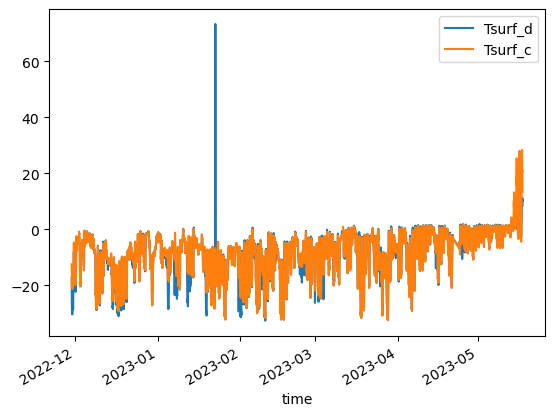

In [41]:
import matplotlib.pyplot as plt
wide_df.set_index("time")['Tsurf_d'].plot(label = 'Tsurf_d')
wide_df.set_index("time")['Tsurf_c'].plot(label = 'Tsurf_c')
plt.legend()

## Scatterplots

In [42]:
src = model_df[model_df.e_sat_curve == 'alduchov']
src = src[src.e_sat_curve == 'alduchov']
src = src[src.surface_measurement == 'Tsurf_c']
src = src[(src.time > "2023-02-01") & (src.time < "2023-02-08")]

alt.Chart(src).mark_area(opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux):Q"),
    alt.Y2("max(latent heat flux):Q"),
    alt.Color("z0:N")
).properties(width = 600) + \
alt.Chart(meas_src).mark_point(size=10, color='black', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q")
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [43]:
model_df.most_config.unique()

array(['Standard', 'Louis b = 12', 'MO Marks Dozier',
       'MO Holtslag de Bruin', 'MO Webb NoahMP', 'MO Beljaars Holtslag',
       'MO Cheng Brutsaert'], dtype=object)

In [44]:
src = model_df[model_df.surface_measurement == 'Tsurf_c']
src = src[src.z0 < 0.001]

src = src[src.most_config == 'MO Webb NoahMP andreas lengths']

src = src[(src.time > "2023-02-01") & (src.time < "2023-02-02")]
meas_src = measured_data[(measured_data.time > "2023-02-01") & (measured_data.time < "2023-02-02")]
(
alt.Chart(src).mark_area(opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux):Q"),
    alt.Y2("max(latent heat flux):Q"),
    alt.Color("e_sat_curve:N")
).properties() + \
alt.Chart(meas_src).mark_point(size=10, color='black', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q")
)).display(renderer = 'svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [45]:
src = model_df[model_df.surface_measurement == 'Tsurf_c']
src = src[src.z0 == 0.0001]
src = src[src.most_config.str.contains('MO')]
src = src[src.e_sat_curve == 'alduchov']

src = src[(src.time > "2023-02-01") & (src.time < "2023-02-02")]
meas_src = measured_data[(measured_data.time > "2023-02-01") & (measured_data.time < "2023-02-02")]
# src = src[(src.time > "2023-03-28") & (src.time < "2023-03-29")]
# meas_src = measured_data[(measured_data.time > "2023-03-28") & (measured_data.time < "2023-03-29")]

# src = src[(src.time > "2023-03-30") & (src.time < "2023-03-31")]
# meas_src = measured_data[(measured_data.time > "2023-03-30") & (measured_data.time < "2023-03-31")]
# src = src[(src.time > "2023-02-05") & (src.time < "2023-02-06")]
# meas_src = measured_data[(measured_data.time > "2023-02-05") & (measured_data.time < "2023-02-06")]   


src = src[~src.most_config.str.contains('Cheng')]
# src = src[~src.most_config.str.contains('MO')]

alt.Chart(src).mark_line().encode(
    alt.X("time:T"),
    alt.Y("median(latent heat flux):Q"),
    alt.Color("config:N"),
    alt.StrokeDash("config:N"),
).properties().configure_legend(labelLimit=1000)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [84]:
src = model_df[model_df.surface_measurement == 'Tsurf_c']
src = src[src.most_config == 'MO Webb NoahMP']
src = src[src.scheme == 'andreas']
src = src[src.z0 < 0.001]

src = src[(src.time > "2023-03-28") & (src.time < "2023-03-29")]
meas_src = measured_data[(measured_data.time > "2023-03-28") & (measured_data.time < "2023-03-29")]

(
alt.Chart(src).mark_area(opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux):Q").title("Latent heat flux (g/m^2/s)"),
    alt.Y2("max(latent heat flux):Q"),
    alt.Color("e_sat_curve:N")
).properties()+ \
alt.Chart(meas_src).mark_point(size=10, color='black', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q")
)).configure_legend(orient='top').display(renderer = 'svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [97]:
src = model_df[model_df.surface_measurement.isin(['Tsurf_c', 'Tsurf_rad_d'])]
src = src[src.z0 == 1.e-05]
src = src[src.most_config == 'MO Webb NoahMP']
src = src[src.scheme == 'andreas']

src = src[(src.time > "2023-03-28") & (src.time < "2023-03-29")]
meas_src = measured_data[(measured_data.time > "2023-03-28") & (measured_data.time < "2023-03-29")]

(
alt.Chart(src).mark_line().encode(
    alt.X("time:T"),
    alt.Y("latent heat flux:Q").title("Latent heat flux (g/m^2/s)"),
    alt.Color("e_sat_curve:N"),
    alt.StrokeDash("surface_measurement:N")
)+ \
alt.Chart(meas_src).mark_point(size=10, color='black', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q")
)).properties(width = 500).configure_legend(orient='top').display(renderer = 'svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [88]:
src = model_df[model_df.surface_measurement.isin(['Tsurf_c', 'Tsurf_rad_d'])]
src = src[src.z0 == 1.e-05]
src = src[src.most_config == 'MO Webb NoahMP']
src = src[src.scheme == 'andreas']

src = src[(src.time > "2023-02-01") & (src.time < "2023-02-02")]
meas_src = measured_data[(measured_data.time > "2023-02-01") & (measured_data.time < "2023-02-02")]

(
alt.Chart(src).mark_area(opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux):Q").title("Latent heat flux (g/m^2/s)"),
    alt.Y2("max(latent heat flux):Q"),
    alt.Color("e_sat_curve:N")
).properties()+ \
alt.Chart(meas_src).mark_point(size=10, color='black', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q")
)).configure_legend(orient='top').display(renderer = 'svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [96]:
src = model_df[model_df.surface_measurement.isin(['Tsurf_c', 'Tsurf_rad_d'])]
src = src[src.z0 == 1.e-05]
src = src[src.most_config == 'MO Webb NoahMP']
src = src[src.scheme == 'andreas']

src = src[(src.time > "2023-02-01") & (src.time < "2023-02-02")]
meas_src = measured_data[(measured_data.time > "2023-02-01") & (measured_data.time < "2023-02-02")]

(
alt.Chart(src).mark_line().encode(
    alt.X("time:T"),
    alt.Y("latent heat flux:Q").title("Latent heat flux (g/m^2/s)"),
    alt.Color("e_sat_curve:N"),
    alt.StrokeDash("surface_measurement:N")
)+ \
alt.Chart(meas_src).mark_point(size=10, color='black', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q")
)).properties(width = 500).configure_legend(orient='top').display(renderer = 'svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [47]:
src.config.unique()

array(['MO Webb NoahMP andreas lengths Tsurf_c e_sat_metpy 1e-05',
       'MO Webb NoahMP andreas lengths Tsurf_c e_sat_alduchov 1e-05',
       'MO Webb NoahMP andreas lengths Tsurf_c e_sat_metpy 5e-05',
       'MO Webb NoahMP andreas lengths Tsurf_c e_sat_alduchov 5e-05',
       'MO Webb NoahMP andreas lengths Tsurf_c e_sat_metpy 0.0001',
       'MO Webb NoahMP andreas lengths Tsurf_c e_sat_alduchov 0.0001',
       'MO Webb NoahMP andreas lengths Tsurf_c e_sat_metpy 0.0005',
       'MO Webb NoahMP andreas lengths Tsurf_c e_sat_alduchov 0.0005'],
      dtype=object)

In [48]:
src = model_df[model_df.surface_measurement == 'Tsurf_c']
src = src[src.z0 < 0.001]
src = src[src.most_config.str.contains("andreas lengths")]
src = src[(src.time > "2023-02-02") & (src.time < "2023-02-06")]
meas_src = measured_data[(measured_data.time > "2023-02-02") & (measured_data.time < "2023-02-06")]

alt.Chart(src).mark_area(opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux):Q"),
    alt.Y2("max(latent heat flux):Q"),
    alt.Color("e_sat_curve:N")
).properties(width = 600) + \
alt.Chart(src).mark_line().encode(
    alt.X("time:T"),
    alt.Y("median(latent heat flux):Q"),
    alt.Color("e_sat_curve:N")
) + \
alt.Chart(meas_src).mark_point(size=10, color='black', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q")
)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [49]:
src = model_df[model_df.surface_measurement == 'Tsurf_c']
src = src[src.z0 < 0.001]
src = src[src.scheme == 'andreas']
src = src[src.most_config == 'MO Webb NoahMP']
src = src[(src.time > "2023-01-01") & (src.time < "2023-02-01")]
meas_src = measured_data[(measured_data.time > "2023-01-01") & (measured_data.time < "2023-02-01")]
alt.Chart(src).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("median(latent heat flux):Q"),
    alt.Color("e_sat_curve:N")
).properties(width = 600).configure_axis(grid=False)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [50]:
src = model_df[model_df.surface_measurement == 'Tsurf_c']
src = src[src.z0 < 0.001]

src = src[(src.time > "2023-03-28") & (src.time < "2023-04-01")]
src = src[src.most_config.str.contains("MO Webb NoahMP")]
meas_src = measured_data[(measured_data.time > "2023-03-28") & (measured_data.time < "2023-04-01")]

(alt.Chart(src).mark_area(opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux):Q"),
    alt.Y2("max(latent heat flux):Q"),
    alt.Color("most_config:N")
).properties(width = 600) + \
alt.Chart(meas_src).mark_point(size=10, color='black', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q")
)).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [51]:
src = model_df[model_df.surface_measurement == 'Tsurf_c']
src = src[src.z0 < 0.001]
src = src[(src.time > "2023-03-28") & (src.time < "2023-04-01")]
src = src[src.most_config == "MO Webb NoahMP"]
src = src[src.scheme == 'andreas']
meas_src = measured_data[(measured_data.time > "2023-03-28") & (measured_data.time < "2023-04-01")]

(alt.Chart(src).mark_area(opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("min(latent heat flux):Q"),
    alt.Y2("max(latent heat flux):Q"),
    alt.Color("e_sat_curve:N")
).properties(width = 600) + \
alt.Chart(meas_src).mark_point(size=10, color='black', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q")
)).configure_legend(orient='top').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [72]:
src

,time,config,latent heat flux,sensible heat flux,zeta,latent heat conductance,sensible heat conductance,scheme,z0,e_sat_curve,surface_measurement,most_config
0,2022-11-29 17:00:00,Standard Tsurf_c e_sat_metpy 1e-05,0.003384,0.002263,NaN,0.003490,0.003490,yang,0.00001,metpy,Tsurf_c,Standard
1,2022-11-29 17:30:00,Standard Tsurf_c e_sat_metpy 1e-05,0.005943,0.000919,NaN,0.004690,0.004690,yang,0.00001,metpy,Tsurf_c,Standard
2,2022-11-29 18:00:00,Standard Tsurf_c e_sat_metpy 1e-05,0.004470,-0.001354,NaN,0.003773,0.003773,yang,0.00001,metpy,Tsurf_c,Standard
3,2022-11-29 18:30:00,Standard Tsurf_c e_sat_metpy 1e-05,0.001274,-0.001298,NaN,0.001657,0.001657,yang,0.00001,metpy,Tsurf_c,Standard
4,2022-11-29 19:00:00,Standard Tsurf_c e_sat_metpy 1e-05,0.000506,-0.000939,NaN,0.001040,0.001040,yang,0.00001,metpy,Tsurf_c,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...
8107,2023-05-17 15:30:00,MO Cheng Brutsaert andreas lengths Tsurf_rad_d...,NaN,NaN,NaN,NaN,NaN,andreas,0.00500,alduchov,Tsurf_rad_d,MO Cheng Brutsaert
8108,2023-05-17 16:00:00,MO Cheng Brutsaert andreas lengths Tsurf_rad_d...,NaN,NaN,NaN,NaN,NaN,andreas,0.00500,alduchov,Tsurf_rad_d,MO Cheng Brutsaert
8109,2023-05-17 16:30:00,MO Cheng Brutsaert andreas lengths Tsurf_rad_d...,NaN,NaN,NaN,NaN,NaN,andreas,0.00500,alduchov,Tsurf_rad_d,MO Cheng Brutsaert
8110,2023-05-17 17:00:00,MO Cheng Brutsaert andreas lengths Tsurf_rad_d...,NaN,NaN,NaN,NaN,NaN,andreas,0.00500,alduchov,Tsurf_rad_d,MO Cheng Brutsaert


In [83]:
src = model_df.query("most_config == 'MO Webb NoahMP'").query("surface_measurement == 'Tsurf_c'").query("scheme == 'andreas'").query("e_sat_curve == 'alduchov'")
src = src[(src.time > "2023-02-01") & (src.time < "2023-02-08")]

meas_src = measured_data[(measured_data.time > "2023-02-01") & (measured_data.time < "2023-02-08")]
(
alt.Chart(src).mark_line().encode(
    alt.X("time:T"),
    alt.Y("latent heat flux:Q"),
    alt.Color("z0:N")
).properties(width = 600) + \
alt.Chart(meas_src).mark_point(size=10, color='black', opacity=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q")
)).display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


(-0.005, 0.03)

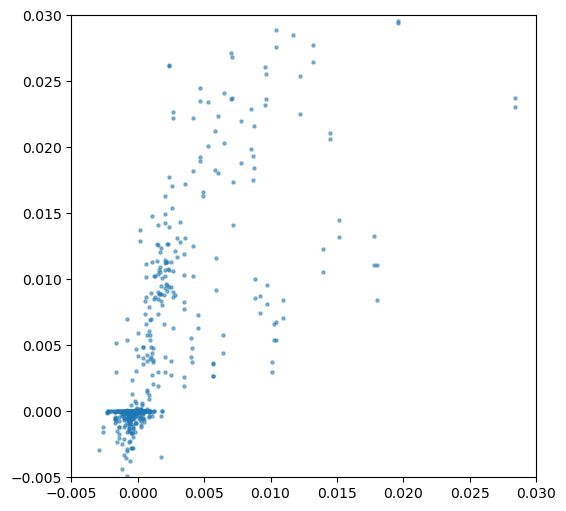

In [54]:
xxx = meas_src.set_index("time")[['value']].merge(src.set_index("time")[['latent heat flux']], on='time')
plt.figure(figsize=(6,6))
plt.scatter(xxx['value'], xxx['latent heat flux'], s=5, alpha=0.5)
plt.xlim(-0.005, 0.03)
plt.ylim(-0.005, 0.03)

In [55]:
src = wide_df[(wide_df.time > "2023-02-01") & (wide_df.time < "2023-02-08")][[
    'time',
    'Tsurf_c',
    'Tsurf_d',
    'Tsurf_ue',
    'Tsurf_uw',
    # 'Tsurfplanck_c',
    # 'Tsurfplanck_d',
    'Tsurf_rad_d'
]]
alt.Chart(src).mark_line().transform_fold([
    'Tsurf_c',
    'Tsurf_d',
    'Tsurf_ue',
    'Tsurf_uw',
    # 'Tsurfplanck_c',
    # 'Tsurfplanck_d',
    'Tsurf_rad_d'
]).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Surface Temperature (˚C)"),
    alt.Color("key:N").title("Surface temp. sensor")
).properties(
    width = 600, 
    height = 300,
    title = 'Surface temperature measurements February 1 - 7, 2023'
).configure_legend(orient = 'top').display(renderer = 'svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [56]:
src = wide_df[(wide_df.time > "2023-02-01") & (wide_df.time < "2023-02-08")][[
    'time',
    'Tsurf_c',
    'Tsurf_d',
    'Tsurf_ue',
    'Tsurf_uw',
    # 'Tsurfplanck_c',
    # 'Tsurfplanck_d',
    'Tsurf_rad_d'
]]
src = src.melt(id_vars=['time'])
src['instrument'] = src['variable'].apply(lambda v: 'LW radiometer' if 'rad' in v else 'Pyrgeometer')

(alt.Chart(src.query("instrument == 'Pyrgeometer'")).mark_errorband(opacity = 1.0).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Surface Temperature (˚C)")
).properties(width = 600) + \
alt.Chart(src.query("instrument == 'LW radiometer'")).mark_line(opacity = 0.65, color='#ff7f0e').encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Surface Temperature (˚C)")
)).properties(
    width = 600, 
    title = 'Surface temperature measurements February 1 - 7, 2023'
).configure_legend(orient = 'top').display(renderer = 'svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [57]:
src = wide_df[[
    'time',
    'Tsurf_c',
    'Tsurf_d',
    'Tsurf_ue',
    'Tsurf_uw',
    # 'Tsurfplanck_c',
    # 'Tsurfplanck_d',
    'Tsurf_rad_d'
]]
alt.Chart(src).mark_line().transform_fold([
    'Tsurf_c',
    'Tsurf_d',
    'Tsurf_ue',
    'Tsurf_uw',
    # 'Tsurfplanck_c',
    # 'Tsurfplanck_d',
    'Tsurf_rad_d'
]).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Surface Temperature (˚C)"),
    alt.Color("key:N").title("Surface temp. sensor")
).properties(
    width = 800, 
    height = 400,
    title = 'Surface temperature measurements, Winter 2022-2023'
).configure_legend(orient = 'top').display(renderer = 'svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting
